In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely import wkt
import math
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./Data/GoRoutesNov2020.csv')
df['geography'] = df['geography'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geography', crs='EPSG:4326')
df.head()

,route_long_name,route_short_name,direction_id,route_variant,geography
0,Niagara Falls / Toronto,12,0,12A,"MULTILINESTRING ((-79.59635 43.20481, -79.5964..."
1,Niagara Falls / Toronto,12,0,12,"MULTILINESTRING ((-79.06370 43.10846, -79.0637..."
2,Niagara Falls / Toronto,12,1,12,"MULTILINESTRING ((-79.82820 43.38892, -79.8281..."
3,Brantford / Aldershot,15,0,15A,"LINESTRING (-79.92266 43.26180, -79.92273 43.2..."
4,Brantford / Aldershot,15,1,15A,"MULTILINESTRING ((-79.85595 43.31301, -79.8560..."


In [4]:
df.dtypes
df = df.to_crs("EPSG:2029")

<AxesSubplot:>

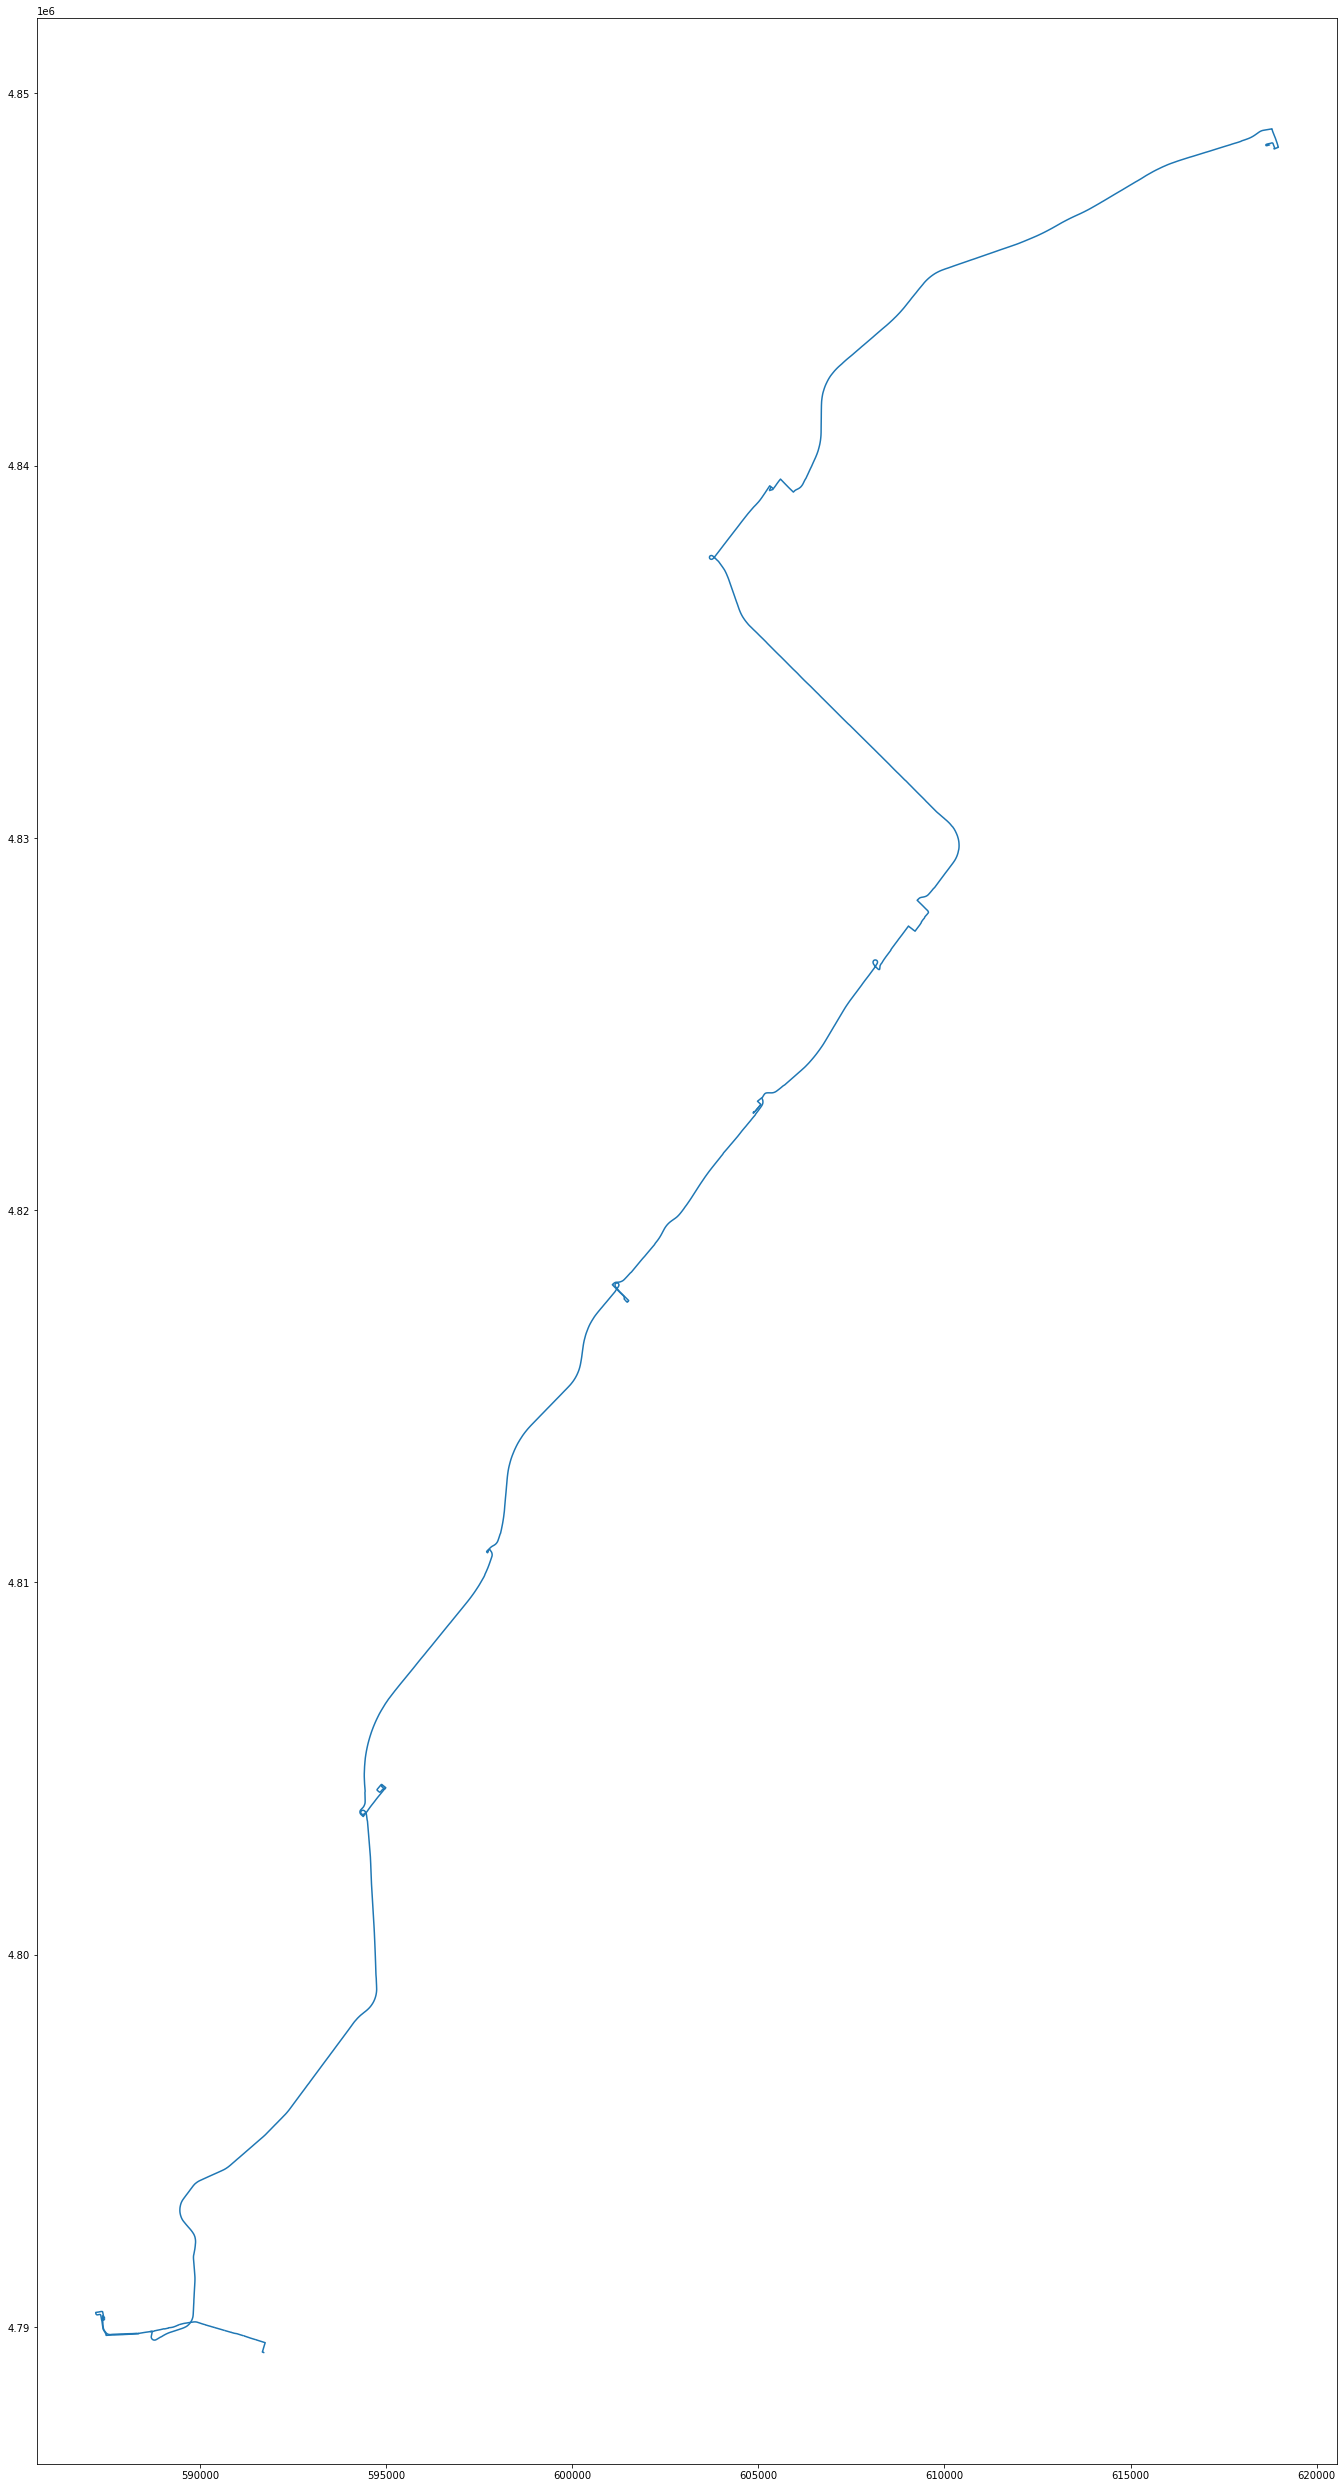

In [5]:
route47 = df[(df['route_variant'] == "47") & (df['direction_id'] == 1)]
route47.plot(figsize=(40,45))

In [6]:
df.crs

<Projected CRS: EPSG:2029>
Name: NAD27(76) / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Ontario - 84°W to 78°W
- bounds: (-84.0, 41.67, -78.0, 55.37)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1927 (1976)
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [7]:
point_delta = 2
point_distance = 2
route = route47.iloc[0]['geography']
distances = np.arange(0, route.length, point_distance)
route_points = [route.interpolate(point_distance) for point_distance in distances] + [route.boundary[1]]
route_point_angles = pd.DataFrame(columns=['Index', 'Point1', 'Point2', 'Angle'])
for index in range(len(route_points)-point_delta):
    p1 = route_points[index]
    p2 = route_points[index+point_delta]
    data = {
        'Index': index,
        'Point1': p1,
        'Point2': p2,
        'Angle': math.degrees(math.atan2(p1.y - p2.y, p1.x - p2.x))
    }
    route_point_angles.loc[index] = data
route_point_angles.head()
    

,Index,Point1,Point2,Angle
0,0,POINT (618735.1385369182 4848622.541483387),POINT (618735.602694446 4848618.568504934),96.663579
1,1,POINT (618735.3706156821 4848620.55499416),POINT (618734.6327305491 4848617.524055251),76.317454
2,2,POINT (618735.602694446 4848618.568504934),POINT (618732.6701087782 4848617.139197116),25.984060
3,3,POINT (618734.6327305491 4848617.524055251),POINT (618730.7074870071 4848616.754338981),11.094576
4,4,POINT (618732.6701087782 4848617.139197116),POINT (618728.7448652362 4848616.369480846),11.094576


<AxesSubplot:>

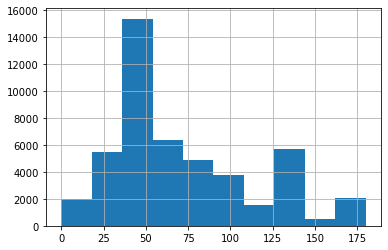

In [15]:
route_point_angles['Angle'] = route_point_angles['Angle'].apply(lambda x: abs(x))
route_point_angles['Angle'].hist()

<AxesSubplot:>

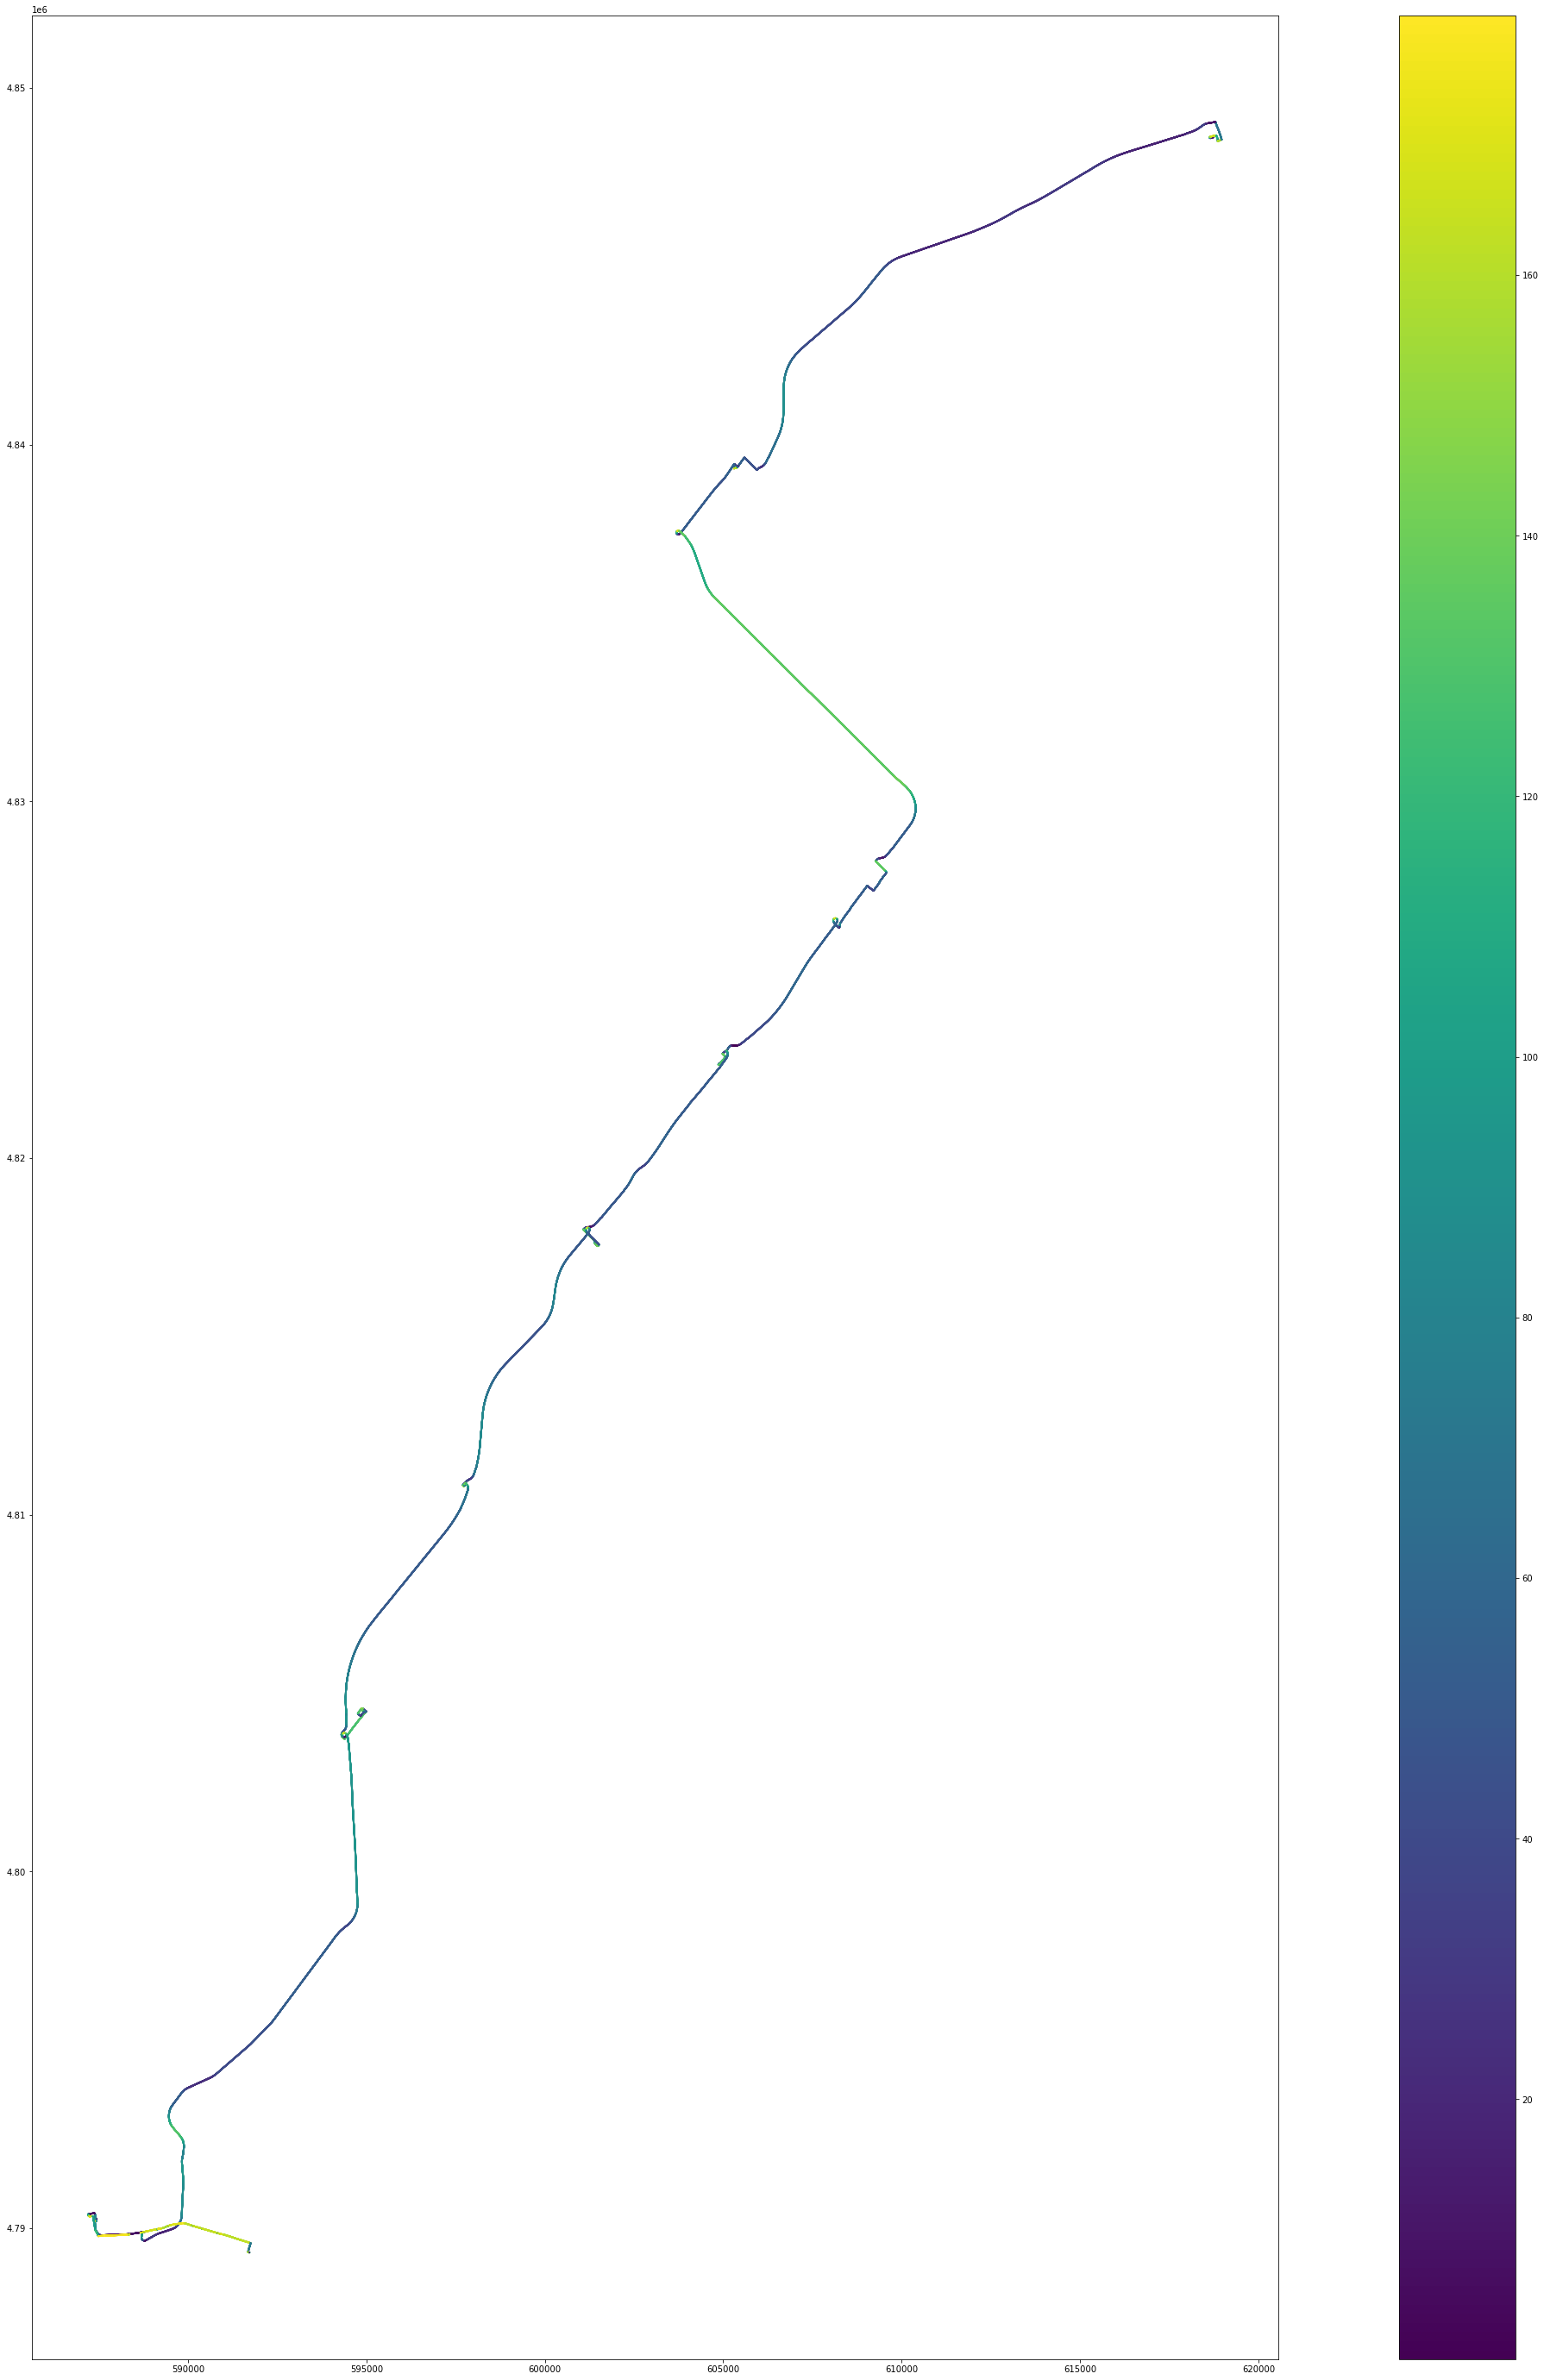

In [17]:
ANGLE_THRESHOLD = 100
big_angles = route_point_angles[route_point_angles['Angle'].apply(lambda x: abs(x) >= 100)]
big_angles = gpd.GeoDataFrame(route_point_angles, geometry='Point1')
big_angles.plot(figsize=(50,50), column='Angle', legend=True, markersize=1)